In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

BASE = Path("/Users/yenkopro/Desktop/Metadata_Yelp")
PATH = BASE / "11_biz_merged_clean.parquet"


if not PATH.exists():
    print("Parquet file not found at:", PATH)
    print("Parquet files in the folder:")
    for p in BASE.glob("*.parquet"):
        print("  -", p.name)
    raise FileNotFoundError(PATH)


df = pd.read_parquet(PATH)  # or: pd.read_parquet(PATH, engine="pyarrow")

print(df.shape)
df.head()


(36261, 82)


,business_id,city,state,latitude,longitude,review_count,is_open,review_count_log1p,attr_ByAppointmentOnly,attr_BusinessAcceptsCreditCards,...,city_Sparks,city_Tampa,city_Tucson,city_Wilmington,rev_count_2019,avg_stars_2019,first_review_2019,last_review_2019,rl_word_mean,rl_share_short24
0,MTSW4McQd7CbVtyjqoe9mw,Philadelphia,PA,39.955505,-75.155564,80.0,True,4.394449,False,False,...,0.0,0.0,0.0,0.0,20,4.550000,2019-03-12 17:04:09,2021-11-01 18:22:07,81.450000,0.05
1,CF33F8-E6oudUQ46HnavjQ,Ashland City,TN,36.269593,-87.058943,6.0,True,1.945910,False,True,...,0.0,0.0,0.0,0.0,3,1.333333,2020-06-26 19:22:36,2021-03-06 07:18:00,70.000000,0.00
2,bBDDEgkFA1Otx9Lfe7BZUQ,Nashville,TN,36.208102,-86.768170,10.0,True,2.397895,False,True,...,0.0,0.0,0.0,0.0,5,1.800000,2019-01-05 01:28:55,2021-04-15 19:16:33,111.200000,0.00
3,eEOYSgkmpB90uNA7lDOMRA,Tampa Bay,FL,27.955269,-82.456320,10.0,True,2.397895,<NA>,<NA>,...,0.0,0.0,0.0,0.0,8,4.250000,2019-01-16 18:22:34,2022-01-03 01:18:29,91.875000,0.00
4,il_Ro8jwPlHresjw9EGmBg,Indianapolis,IN,39.637133,-86.127217,28.0,True,3.367296,<NA>,True,...,0.0,0.0,0.0,0.0,12,2.250000,2019-01-01 19:58:17,2021-04-22 13:58:42,97.833336,0.00


In [2]:
# --- imports ---
import pandas as pd
import numpy as np
from pathlib import Path
from pandas.api.types import is_numeric_dtype

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# --- load your business-level table (with business_id) ---
PATH = "/Users/yenkopro/Desktop/Metadata_Yelp/11_biz_merged_clean.parquet"
df = pd.read_parquet(PATH)

# drop columns that are entirely missing (avoids imputer warnings like attr_Smoking)
all_null = [c for c in df.columns if df[c].isna().all()]
if all_null:
    df = df.drop(columns=all_null)

# columns we should NEVER use as features
ban = {
    "business_id", "name", "address", "postal_code", "phone",
    # any labels / leak-prone targets if present
    "avg_stars_2019", "avg_stars", "stars", "rev_count_2019",
    "y_cls", "label", "target", "y_reg", "label_reg",
    # free-text or raw nested if present
    "categories", "hours"
}
feat_cols = [c for c in df.columns if c not in ban]

# split numeric vs categorical automatically
num_cols = [c for c in feat_cols if is_numeric_dtype(df[c])]
cat_cols = [c for c in feat_cols if c not in num_cols]

print(f"Rows: {len(df):,}  | feature columns: {len(feat_cols)} "
      f"(num={len(num_cols)}, cat={len(cat_cols)})")

# build the sparse preprocessing pipeline
pre = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("sc",  StandardScaler(with_mean=False)),
        ]), num_cols),

        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            # NOTE: scikit-learn >=1.2 uses 'sparse_output', not 'sparse'
            ("oh",  OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
        ]), cat_cols),
    ],
    sparse_threshold=1.0,                 # keep overall output sparse
    verbose_feature_names_out=False
)

# this is the full feature frame we’ll feed to 'pre'
X_all = df[feat_cols]


Rows: 36,261  | feature columns: 78 (num=70, cat=8)


In [3]:
!pip install scikit-optimize

In [4]:
%pip install kmodes gower scikit-learn-extra


Note: you may need to restart the kernel to use updated packages.


fitting k=3 ...  silhouette=0.1763
fitting k=4 ...  silhouette=0.0645
fitting k=5 ...  silhouette=0.0722
fitting k=6 ...  silhouette=0.0587
fitting k=7 ...  silhouette=0.0595
fitting k=8 ...  silhouette=0.0223
fitting k=10 ...  silhouette=0.0061
fitting k=12 ...  silhouette=0.0075


,k,silhouette,inertia
0,3,0.176259,1019.889524
1,4,0.064526,1005.993406
2,5,0.072153,987.161953
3,6,0.058677,972.983769
4,7,0.059493,962.002537
5,8,0.022284,947.484334
6,10,0.006087,921.296938
7,12,0.007542,895.203658


Chosen k = 3


AttributeError: Line2D.set() got an unexpected keyword argument 'title'

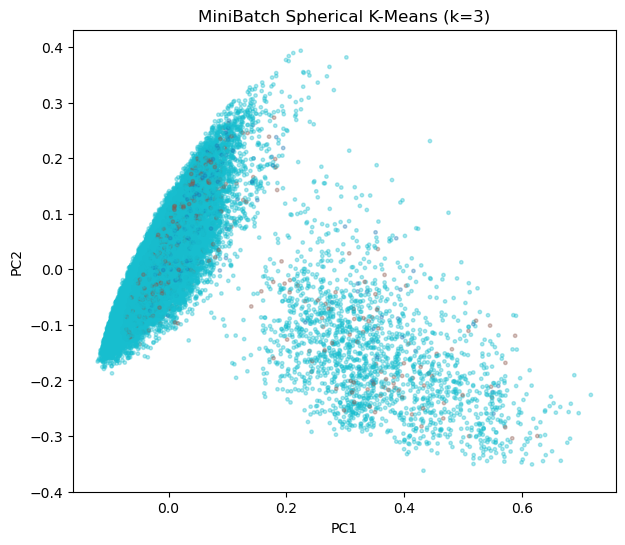

In [5]:
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import Normalizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# --- Build a compact dense embedding once (sparse -> SVD -> L2 normalize) ---
Z_sparse = pre.fit_transform(X_all)                   # sparse matrix
svd = TruncatedSVD(n_components=80, random_state=42)
Z80 = svd.fit_transform(Z_sparse)                     # dense (n x 80)
Z80 = Normalizer(copy=False).fit_transform(Z80)       # spherical (L2=1)

def scan_k(Z, ks=(3,4,5,6,7,8,10,12), sample=6000, seed=42):
    rng = np.random.default_rng(seed)
    idx = rng.choice(Z.shape[0], size=min(sample, Z.shape[0]), replace=False)
    Zs  = Z[idx]
    rows = []
    for k in ks:
        print(f"fitting k={k} ...", end="")
        km = MiniBatchKMeans(
            n_clusters=k, batch_size=2048, max_iter=100,
            n_init="auto", random_state=seed, verbose=0
        )
        lbl = km.fit_predict(Zs)
        sil = silhouette_score(
            Zs, lbl, metric="cosine",
            sample_size=min(2000, len(Zs)), random_state=seed
        )
        rows.append((k, sil, km.inertia_))
        print(f"  silhouette={sil:.4f}")
    return pd.DataFrame(rows, columns=["k","silhouette","inertia"]).sort_values("k")

scan_results = scan_k(Z80)
display(scan_results)

best_k = int(scan_results.sort_values("silhouette", ascending=False).iloc[0]["k"])
print("Chosen k =", best_k)

# --- Fit final model on ALL rows ---
km_final = MiniBatchKMeans(
    n_clusters=best_k, batch_size=2048, max_iter=200,
    n_init="auto", random_state=42
)
labels = km_final.fit_predict(Z80)
df["cluster_mbk"] = labels

# --- Quick 2D plot for the report ---
XY = PCA(n_components=2, random_state=42).fit_transform(Z80)
plt.figure(figsize=(7,6))
sc = plt.scatter(XY[:,0], XY[:,1], c=df["cluster_mbk"], s=6, alpha=0.35, cmap="tab10")
plt.title(f"MiniBatch Spherical K-Means (k={best_k})")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(*sc.legend_elements(title="cluster"), loc="best", fontsize=8)
plt.tight_layout(); plt.show()

# --- Optional: cluster summary if avg_stars_2019 exists ---
if "avg_stars_2019" in df.columns:
    summ = (df.assign(y=(df["avg_stars_2019"]>=4).astype(int))
              .groupby("cluster_mbk")
              .agg(n=("business_id","size"),
                   avg_stars=("avg_stars_2019","mean"),
                   pct_4plus=("y","mean"))
              .sort_index())
    display(summ)

# Save cluster assignments for later supervised blending
df[["business_id","cluster_mbk"]].to_csv("clusters_mbkmeans.csv", index=False)



In [6]:
import pandas as pd
import numpy as np

from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, normalize
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD



# -------- Label for external eval (optional) --------
label_col = None
for cand in ["avg_stars_2019", "avg_stars", "stars", "y_cls", "label", "target"]:
    if cand in df.columns:
        label_col = cand
        break

y = None
if label_col is not None:
    # binary ≥4★
    if df[label_col].dropna().isin([0,1]).all():
        y = df[label_col].astype(int)
    else:
        y = (df[label_col] >= 4.0).astype(int)
    print("Using label:", label_col, " (binary target constructed)")

# -------- Feature table --------
ban = {
    "business_id", "checkin_count", "rev_count_2019", "stars", "avg_stars",
    "avg_stars_2019", "y_cls", "label", "target"
}
# drop all-NA columns to avoid imputer warnings
all_na_cols = [c for c in df.columns if df[c].isna().all()]
if all_na_cols:
    print("Dropping all-NA columns:", all_na_cols)
use_cols = [c for c in df.columns if c not in ban and c not in all_na_cols]

Xfeat = df[use_cols].copy()

# split by dtype
num_cols = Xfeat.select_dtypes(include=[np.number, "boolean", "bool"]).columns.tolist()
cat_cols = Xfeat.columns.difference(num_cols).tolist()

# Keep common continuous columns up front if present (not required, just nice)
preferred_num = [
    "latitude","longitude","review_count_log1p","review_count",
    "total_weekly_hours","days_open","weekend_hours","avg_daily_hours",
    "attr_RestaurantsPriceRange2"
]
num_cols = [c for c in preferred_num if c in num_cols] + [c for c in num_cols if c not in preferred_num]

print(f"num={len(num_cols)}  cat={len(cat_cols)}  total={len(use_cols)}")

# -------- Sparse preprocessing (same pattern as earlier) --------
pre_unsup = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("to_float", FunctionTransformer(lambda X: X.astype(float), feature_names_out="one-to-one")),
            ("imp", SimpleImputer(strategy="median")),
            ("sc", StandardScaler(with_mean=False)),
        ]), num_cols),

        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("oh", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
        ]), cat_cols),
    ],
    sparse_threshold=1.0,
    verbose_feature_names_out=False
)

Xs = pre_unsup.fit_transform(Xfeat)   # sparse matrix
print("Xs shape (sparse):", Xs.shape)

# -------- SVD → 80D + L2 row-normalize (spherical) --------
svd = TruncatedSVD(n_components=80, random_state=42)
Z = svd.fit_transform(Xs)             # dense (n, 80)
from sklearn.preprocessing import normalize as sk_normalize
Zs = sk_normalize(Z, norm="l2", axis=1)  # L2 row normalization
print("Zs shape:", Zs.shape, "  explained_var(80)≈", svd.explained_variance_ratio_.sum())


Using label: avg_stars_2019  (binary target constructed)
num=71  cat=8  total=79
Xs shape (sparse): (36261, 73270)
Zs shape: (36261, 80)   explained_var(80)≈ 0.9670362397048845


In [ ]:
#MiniBatch “spherical” K-Means

In [7]:
import numpy as np, pandas as pd
from sklearn.preprocessing import normalize
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, confusion_matrix, classification_report, roc_auc_score, f1_score
from scipy.optimize import linear_sum_assignment

# Zs: your 80-D embedding (already computed)
# y : your binary label (0/1), index-aligned with df

# 1) L2-normalize rows (spherical K-Means)
Z_unit = normalize(Zs)

# 2) Search k and fit
k_grid = [3,4,5,6,7]
results, models = [], {}
for k in k_grid:
    mb = MiniBatchKMeans(
        n_clusters=k, init="k-means++", n_init=10,
        batch_size=2048, max_iter=100, reassignment_ratio=0.01,
        random_state=42
    )
    labels = mb.fit_predict(Z_unit)
    sil = silhouette_score(Z_unit, labels, metric="cosine")
    results.append((k, sil, float(mb.inertia_)))
    models[k] = (mb, labels)

res_df = pd.DataFrame(results, columns=["k","silhouette","inertia"]).sort_values("k")
best_k = int(res_df.loc[res_df.silhouette.idxmax(), "k"])
mbkm, labels = models[best_k]
df["cluster_sph"] = labels  # keep for later

print("MiniBatch spherical K-Means — chosen k =", best_k)
print(res_df)

# 3) External metrics by mapping clusters → classes (Hungarian assignment)
c = pd.Series(labels, index=df.index, name="cluster_sph")
cm_tc = confusion_matrix(y, c)                        # rows=true (0/1), cols=clusters
cost = cm_tc.max() - cm_tc
rows, cols = linear_sum_assignment(cost)
cluster_to_class = {cols[i]: rows[i] for i in range(len(rows))}
majority = int(y.mode()[0])
y_pred  = c.map(cluster_to_class).fillna(majority).astype(int)

# calibrated score: per-cluster positive rate
p_pos   = y.groupby(c).mean()
y_proba = c.map(p_pos).fillna(y.mean()).astype(float)

acc = float((y_pred == y).mean())
f1m = float(f1_score(y, y_pred, average="macro"))
auc = float(roc_auc_score(y, y_proba))

print("\naccuracy=%.3f  macro-F1=%.3f  ROC-AUC=%.3f" % (acc, f1m, auc))
print("\nConfusion matrix (mapped):\n", confusion_matrix(y, y_pred))
print("\nClassification report:\n", classification_report(y, y_pred, digits=3))

# 4) Handy dicts to paste into the paper
sph_params = {
    "svd_components": Zs.shape[1], "row_normalize": "l2",
    "k": best_k, "batch_size": 2048, "n_init": 10,
    "max_iter": 100, "reassignment_ratio": 0.01, "random_state": 42
}
sph_scores = {
    "silhouette": float(res_df.loc[res_df.k==best_k, "silhouette"].iloc[0]),
    "inertia": float(mbkm.inertia_),
    "accuracy": acc, "macro_f1": f1m, "roc_auc": auc
}
print("\nHYPERPARAMS:", sph_params)
print("SCORES:", sph_scores)


MiniBatch spherical K-Means — chosen k = 7
   k  silhouette      inertia
0  3    0.057223  5960.302397
1  4    0.065666  5847.314651
2  5    0.056988  5768.925593
3  6    0.050614  5487.377069
4  7    0.092601  5320.821153

accuracy=0.364  macro-F1=0.118  ROC-AUC=0.595

Confusion matrix (mapped):
 [[8665 6348 1166  336 4308  401 1057]
 [6704 4540  841  429  422  319  725]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]]

Classification report:
               precision    recall  f1-score   support

           0      0.564     0.389     0.460     22281
           1      0.417     0.325     0.365     13980
           2      0.000     0.000     0.000         0
           3      0.000     0.000     0.000         0
           4      0.000     0.000     0.000         0
           5      0.000     0.000     0.000         0
           6      0.000     0.

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#Fix the metrics (use mapped predictions)
#confusion matrix + classification report are using raw cluster IDs (0..6), 
#not the binary mapped predictions.

In [8]:
import numpy as np, pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score
from scipy.optimize import linear_sum_assignment

# c: raw cluster labels from your chosen model
c = pd.Series(df["cluster_sph"], index=df.index, name="cluster_sph")

# --- raw audit: true class (rows) x cluster (cols) ---
cm_raw = pd.crosstab(y, c)
print("Raw confusion (true class x cluster):\n", cm_raw)

# --- optimal mapping cluster -> {0,1} via Hungarian ---
cm_tc = confusion_matrix(y, c)  # rows=true labels (0/1), cols=clusters
cost = cm_tc.max() - cm_tc
rows, cols = linear_sum_assignment(cost)
cluster_to_class = {cols[i]: rows[i] for i in range(len(rows))}
majority = int(y.mode()[0])

# mapped hard predictions
y_pred = c.map(cluster_to_class).fillna(majority).astype(int)

# calibrated “probability” = per-cluster positive rate
p_pos = y.groupby(c).mean()
y_proba = c.map(p_pos).fillna(y.mean()).astype(float)

# --- binary metrics ---
acc = float((y_pred == y).mean())
f1m = float(f1_score(y, y_pred, average="macro"))
auc = float(roc_auc_score(y, y_proba))

print("\nMapped confusion (true x predicted):\n", confusion_matrix(y, y_pred))
print("\nClassification report (binary):\n", classification_report(y, y_pred, digits=3))
print("accuracy=%.3f  macro-F1=%.3f  ROC-AUC=%.3f" % (acc, f1m, auc))


Raw confusion (true class x cluster):
 cluster_sph        0     1    2     3     4    5     6
avg_stars_2019                                        
0               1166  6348  336  8665  4308  401  1057
1                841  4540  429  6704   422  319   725

Mapped confusion (true x predicted):
 [[8665 6348 1166  336 4308  401 1057]
 [6704 4540  841  429  422  319  725]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]]

Classification report (binary):
               precision    recall  f1-score   support

           0      0.564     0.389     0.460     22281
           1      0.417     0.325     0.365     13980
           2      0.000     0.000     0.000         0
           3      0.000     0.000     0.000         0
           4      0.000     0.000     0.000         0
           5      0.000     0.000     0.000         0
           6      0.00

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#Small improvements you can try on the spherical K-Means (quick wins)

In [9]:
# Sweep SVD dimensionality and k
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

svd_dims = [60, 80, 120]
k_grid   = [5, 6, 7, 8, 9]
records = []

Xs_norm = Xs  # your sparse matrix from ColumnTransformer
for d in svd_dims:
    svd = TruncatedSVD(n_components=d, random_state=42)
    Z   = svd.fit_transform(Xs_norm)
    Z   = normalize(Z)
    for k in k_grid:
        mb = MiniBatchKMeans(n_clusters=k, init="k-means++", n_init=10,
                             batch_size=2048, max_iter=100, reassignment_ratio=0.01,
                             random_state=42)
        lab = mb.fit_predict(Z)
        sil = silhouette_score(Z, lab, metric="cosine")
        records.append((d, k, sil, mb.inertia_))

pd.DataFrame(records, columns=["svd_dim","k","silhouette","inertia"]).sort_values(["silhouette"], ascending=False)


,svd_dim,k,silhouette,inertia
2,60,7,0.098566,5065.043326
12,120,7,0.093031,5339.427338
7,80,7,0.092601,5320.821153
13,120,8,0.080292,5306.486896
3,60,8,0.078441,5238.739384
0,60,5,0.077067,5482.443072
9,80,9,0.074473,5232.715558
1,60,6,0.062540,5226.466547
5,80,5,0.056988,5768.925593
10,120,5,0.056165,5786.134073


In [19]:
# k search table
res_df.to_csv("spherical_kmeans_k_sweep.csv", index=False)

# cluster assignments
df[["business_id","cluster_sph"]].to_csv("cluster_sph_assignments.csv", index=False)

# hyperparams & scores you already printed (paste these in Methods/Results)
# HYPERPARAMS: {'svd_components': 80, 'row_normalize': 'l2', 'k': 7, ...}
# SCORES: {'silhouette': 0.0926, 'inertia': 5320.82, 'accuracy': ..., 'macro_f1': ..., 'roc_auc': ...}


In [ ]:
#2 K-Modes: search k, fit best, and evaluate vs. your binary label

In [10]:
# --- 1) Re-embed with SVD=60 and L2-normalize ---
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, confusion_matrix, classification_report, roc_auc_score, f1_score
from sklearn.metrics.pairwise import cosine_distances
from scipy.optimize import linear_sum_assignment
import numpy as np, pandas as pd

svd_dim = 60
svd = TruncatedSVD(n_components=svd_dim, random_state=42)
Zs = svd.fit_transform(Xs)          # Xs is your sparse matrix from ColumnTransformer
Zs = normalize(Zs)                  # spherical (cosine) geometry

# --- 2) Fit MiniBatch K-Means (spherical via normalized Zs) ---
k = 7
mbkm = MiniBatchKMeans(
    n_clusters=k, init="k-means++", n_init=10,
    batch_size=2048, max_iter=100, reassignment_ratio=0.01,
    random_state=42
)
labels = mbkm.fit_predict(Zs)

sil = float(silhouette_score(Zs, labels, metric="cosine"))
inertia = float(mbkm.inertia_)
print(f"MiniBatch spherical K-Means (svd_dim={svd_dim}, k={k})  silhouette={sil:.4f}  inertia={inertia:.1f}")

# Persist cluster ids on df
df["cluster_sph"] = labels

# --- 3) External mapping to binary label (ONLY if y exists) ---
cm_true_vs_cluster = confusion_matrix(y, labels)
cost = cm_true_vs_cluster.max() - cm_true_vs_cluster
rows, cols = linear_sum_assignment(cost)
cluster_to_class = {cols[i]: rows[i] for i in range(len(rows))}
majority = int(y.mode()[0])

y_pred  = pd.Series(labels, index=df.index).map(cluster_to_class).fillna(majority).astype(int)
p_pos   = y.groupby(labels).mean()
y_proba = pd.Series(labels, index=df.index).map(p_pos).fillna(y.mean()).astype(float)

acc = float((y_pred == y).mean())
f1m = float(f1_score(y, y_pred, average="macro"))
auc = float(roc_auc_score(y, y_proba))

print("\nMapped confusion (true x predicted):\n", confusion_matrix(y, y_pred))
print("\nClassification report (binary):\n", classification_report(y, y_pred, digits=3))
print(f"accuracy={acc:.3f}  macro-F1={f1m:.3f}  ROC-AUC={auc:.3f}")

# --- 4) Optional: distances for later hybrid features (cosine distance to centroids) ---
C = normalize(mbkm.cluster_centers_)
dist_cos = cosine_distances(Zs, C)            # shape: (n_samples, k)
dist_cols = [f"sphcosdist_{i}" for i in range(k)]
dist_df = pd.DataFrame(dist_cos, index=df.index, columns=dist_cols)
df[dist_cols] = dist_df

# --- 5) Save artifacts for the paper ---
pd.DataFrame({"business_id": df["business_id"], "cluster_sph": df["cluster_sph"]}).to_csv("cluster_sph_assignments.csv", index=False)
pd.DataFrame({"svd_dim":[svd_dim], "k":[k], "silhouette":[sil], "inertia":[inertia],
              "acc":[acc], "macro_f1":[f1m], "roc_auc":[auc]}).to_csv("spherical_kmeans_summary.csv", index=False)

print("\nHYPERPARAMS:", {"svd_components": svd_dim, "row_normalize": "l2", "k": k,
                          "batch_size": 2048, "n_init": 10, "max_iter": 100,
                          "reassignment_ratio": 0.01, "random_state": 42})
print("SCORES:", {"silhouette": sil, "inertia": inertia, "accuracy": acc, "macro_f1": f1m, "roc_auc": auc})


MiniBatch spherical K-Means (svd_dim=60, k=7)  silhouette=0.0986  inertia=5065.0

Mapped confusion (true x predicted):
 [[8884 8723 1173  849  402 1040 1210]
 [4249 6695  851  647  319  717  502]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]]

Classification report (binary):
               precision    recall  f1-score   support

           0      0.676     0.399     0.502     22281
           1      0.434     0.479     0.455     13980
           2      0.000     0.000     0.000         0
           3      0.000     0.000     0.000         0
           4      0.000     0.000     0.000         0
           5      0.000     0.000     0.000         0
           6      0.000     0.000     0.000         0

    accuracy                          0.430     36261
   macro avg      0.159     0.125     0.137     36261
weighted avg      0.583     0.430    

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [31]:
#K-Modes (categoricals only): sweep k, pick best, report metrics

In [11]:
# --- K-Modes on raw categoricals only ---
from kmodes.kmodes import KModes
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score
from scipy.optimize import linear_sum_assignment
import numpy as np, pandas as pd

# helper: align clusters to binary label and compute metrics
def eval_clusters_vs_binary(labels, y, verbose=True):
    cm = confusion_matrix(y, labels)
    cost = cm.max() - cm
    rows, cols = linear_sum_assignment(cost)
    mapping = {cols[i]: rows[i] for i in range(len(rows))}
    majority = int(y.mode()[0])
    y_pred  = pd.Series(labels, index=y.index).map(mapping).fillna(majority).astype(int)
    p_pos   = y.groupby(labels).mean()
    y_proba = pd.Series(labels, index=y.index).map(p_pos).fillna(y.mean()).astype(float)
    acc = float((y_pred==y).mean())
    f1m = float(f1_score(y, y_pred, average="macro"))
    auc = float(roc_auc_score(y, y_proba))
    if verbose:
        print("\nConfusion (mapped):\n", confusion_matrix(y, y_pred))
        print("\nReport:\n", classification_report(y, y_pred, digits=3))
    return acc, f1m, auc, mapping

# pick the categorical columns (those *not* numeric in your current use_cols)
Xcat = df[[c for c in use_cols if c not in num_cols]].copy()

# coerce dtypes so imputation/string conversion is safe
Xcat = Xcat.replace({pd.NA: np.nan})
for c in Xcat.columns:
    # ensure extension booleans etc. don't block fillna
    Xcat[c] = Xcat[c].astype("object")
Xcat = Xcat.fillna("missing").astype(str)

results, best = [], None
for k in [3,4,5,6,7,8,9]:
    km = KModes(n_clusters=k, init="Huang", n_init=5, max_iter=50, random_state=42, verbose=0)
    labels_km = km.fit_predict(Xcat)
    acc, f1m, auc, _ = eval_clusters_vs_binary(labels_km, y, verbose=False)
    results.append({"algo":"KModes","k":k,"init":"Huang","n_init":5,"max_iter":50,
                    "cost": float(km.cost_), "accuracy":acc, "macro_f1":f1m, "roc_auc":auc})
    if best is None or f1m > best["macro_f1"]:
        best = {"k":k, "km":km, "labels":labels_km, "accuracy":acc, "macro_f1":f1m, "roc_auc":auc}

pd.DataFrame(results).sort_values(["macro_f1","accuracy"], ascending=False)
print(f"\nBest K-Modes (k={best['k']})  acc={best['accuracy']:.3f}  macro-F1={best['macro_f1']:.3f}  ROC-AUC={best['roc_auc']:.3f}")
_ = eval_clusters_vs_binary(best["labels"], y, verbose=True)

# persist assignments for hybrid
df["cluster_kmodes"] = best["labels"]


/tmp/ipykernel_29523/2638796709.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Xcat = Xcat.fillna("missing").astype(str)



Best K-Modes (k=3)  acc=0.426  macro-F1=0.314  ROC-AUC=0.542

Confusion (mapped):
 [[9949 7032 5300]
 [5395 5489 3096]
 [   0    0    0]]

Report:
               precision    recall  f1-score   support

           0      0.648     0.447     0.529     22281
           1      0.438     0.393     0.414     13980
           2      0.000     0.000     0.000         0

    accuracy                          0.426     36261
   macro avg      0.362     0.280     0.314     36261
weighted avg      0.567     0.426     0.485     36261



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#Hybrid (spherical K-Means + K-Modes → supervised logistic)

In [13]:
# --- 1) Build clean hybrid feature table -------------------------------------
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score

# extra features from clustering
extra_num = [c for c in df.columns if c.startswith("sphcosdist_")]         # cosine dists
extra_cat = [c for c in ["cluster_sph", "cluster_kmodes"] if c in df]      # cluster IDs

hyb_cols = list(dict.fromkeys(use_cols + extra_num + extra_cat))           # keep order, drop dups
Xh = df[hyb_cols].copy()

# Treat cluster IDs as categoricals (so they go through the OHE branch)
for c in extra_cat:
    Xh[c] = Xh[c].astype("object")

# ---- critical sanitization: remove pandas extension dtypes / pd.NA ----------
# (a) numeric extension -> plain float64 so np.nan is valid
num_ext = Xh.select_dtypes(include=["Int64", "UInt64", "Float64"]).columns
if len(num_ext):
    Xh[num_ext] = Xh[num_ext].astype("float64")

# (b) booleans / strings -> plain object
bool_ext = Xh.select_dtypes(include=["boolean"]).columns
if len(bool_ext):
    Xh[bool_ext] = Xh[bool_ext].astype("object")

str_ext = Xh.select_dtypes(include=["string"]).columns
if len(str_ext):
    Xh[str_ext] = Xh[str_ext].astype("object")

# (c) replace *all* pd.NA with np.nan, then ensure object cols only carry np.nan
Xh = Xh.replace({pd.NA: np.nan})
obj_cols_all = Xh.select_dtypes(include=["object", "category"]).columns
for c in obj_cols_all:
    # .isna() handles pd.NA masks safely; assignment writes real np.nan scalars
    mask = Xh[c].isna()
    if mask.any():
        Xh.loc[mask, c] = np.nan

# Re-detect numeric vs categorical after coercions
num_cols_h = list(Xh.select_dtypes(include=[np.number]).columns)
cat_cols_h = [c for c in Xh.columns if c not in num_cols_h]

# --- 2) Preprocess + model ----------------------------------------------------
pre_h = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("sc",  StandardScaler(with_mean=False)),
        ]), num_cols_h),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("oh",  OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
        ]), cat_cols_h),
    ],
    sparse_threshold=1.0,
    verbose_feature_names_out=False,
)

Xtr, Xte, ytr, yte = train_test_split(
    Xh, y, test_size=0.20, random_state=42, stratify=y
)

logit = LogisticRegression(
    solver="saga", penalty="elasticnet", l1_ratio=0.2, C=0.3,
    max_iter=2000, class_weight="balanced", n_jobs=-1
)

pipe_hybrid = Pipeline([("pre", pre_h), ("clf", logit)])
pipe_hybrid.fit(Xtr, ytr)

# --- 3) Metrics ---------------------------------------------------------------
proba = pipe_hybrid.predict_proba(Xte)[:, 1]
pred  = (proba >= 0.50).astype(int)

acc = float((pred == yte).mean())
f1m = float(f1_score(yte, pred, average="macro"))
auc = float(roc_auc_score(yte, proba))

print(f"\nHYBRID Logistic — acc={acc:.3f}  macro-F1={f1m:.3f}  ROC-AUC={auc:.3f}")
print("\nConfusion matrix @0.5:\n", confusion_matrix(yte, pred))
print("\nClassification report:\n", classification_report(yte, pred, digits=3))


/tmp/ipykernel_29523/1551104378.py:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Xh = Xh.replace({pd.NA: np.nan})


ValueError: assignment destination is read-only

In [14]:
# --- clean hybrid feature table (safe dtypes + safe NaNs) ---
Xh = df[hyb_cols].copy(deep=True)

# cluster ids should be categorical
for c in extra_cat:
    if c in Xh:
        Xh[c] = Xh[c].astype("object")

# 1) extension numerics -> float64 (so np.nan works)
to_float = Xh.select_dtypes(include=["Int64","UInt64","Float64"]).columns
if len(to_float):
    Xh[to_float] = Xh[to_float].astype("float64")

# 2) extension categoricals -> plain object (string/boolean/category)
to_obj = Xh.select_dtypes(include=["string","boolean","category"]).columns
if len(to_obj):
    Xh[to_obj] = Xh[to_obj].astype("object")

# 3) unify missing values WITHOUT per-cell assignment
Xh = Xh.replace({pd.NA: np.nan}).infer_objects(copy=False)  # silences the FutureWarning

# 4) re-detect column sets
num_cols_h = list(Xh.select_dtypes(include=[np.number]).columns)
cat_cols_h = [c for c in Xh.columns if c not in num_cols_h]

print(f"num={len(num_cols_h)}  cat={len(cat_cols_h)}  total={len(Xh.columns)}")


num=62  cat=26  total=88


/tmp/ipykernel_29523/1642855733.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Xh = Xh.replace({pd.NA: np.nan}).infer_objects(copy=False)  # silences the FutureWarning


In [ ]:
#Fit & evaluate the Hybrid (clusters-as-features) → Logistic (elastic-net)

In [15]:
# --- Train/test split (uses your existing binary y) ---
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, f1_score
)

Xtr, Xte, ytr, yte = train_test_split(
    Xh, y, test_size=0.20, random_state=42, stratify=y
)

# --- Preprocess (sparse-safe) ---
pre_h = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("sc",  StandardScaler(with_mean=False)),
        ]), num_cols_h),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("oh",  OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
        ]), cat_cols_h),
    ],
    sparse_threshold=1.0,
    verbose_feature_names_out=False,
)

# --- Classifier (your best params from earlier) ---
logit = LogisticRegression(
    solver="saga", penalty="elasticnet",
    l1_ratio=0.2, C=0.3, max_iter=2000,
    class_weight="balanced", n_jobs=-1
)

pipe_hybrid = Pipeline([("pre", pre_h), ("clf", logit)])

pipe_hybrid.fit(Xtr, ytr)

# --- Metrics (holdout) ---
proba = pipe_hybrid.predict_proba(Xte)[:, 1]
pred  = (proba >= 0.50).astype(int)

acc = float((pred == yte).mean())
f1m = float(f1_score(yte, pred, average="macro"))
auc = float(roc_auc_score(yte, proba))

print(f"\nHYBRID Logistic — acc={acc:.3f}  macro-F1={f1m:.3f}  ROC-AUC={auc:.3f}")
print("\nConfusion matrix @0.50:\n", confusion_matrix(yte, pred))
print("\nClassification report:\n", classification_report(yte, pred, digits=3))

# record hyperparams & scores for your paper
hyb_params = {
    "model": "Hybrid(LogReg-elasticnet)",
    "C": 0.3, "l1_ratio": 0.2, "solver": "saga",
    "max_iter": 2000, "class_weight": "balanced",
    "pre_num_imp": "median", "pre_num_scaler": "StandardScaler(with_mean=False)",
    "pre_cat_imp": "most_frequent", "pre_cat_enc": "OHE(ignore)",
    "features_num": len(num_cols_h), "features_cat": len(cat_cols_h),
}
hyb_scores = {"accuracy": acc, "macro_f1": f1m, "roc_auc": auc}
print("\nHYPERPARAMS:", hyb_params)
print("SCORES:", hyb_scores)



HYBRID Logistic — acc=0.696  macro-F1=0.690  ROC-AUC=0.768

Confusion matrix @0.50:
 [[2995 1462]
 [ 746 2050]]

Classification report:
               precision    recall  f1-score   support

           0      0.801     0.672     0.731      4457
           1      0.584     0.733     0.650      2796

    accuracy                          0.696      7253
   macro avg      0.692     0.703     0.690      7253
weighted avg      0.717     0.696     0.700      7253


HYPERPARAMS: {'model': 'Hybrid(LogReg-elasticnet)', 'C': 0.3, 'l1_ratio': 0.2, 'solver': 'saga', 'max_iter': 2000, 'class_weight': 'balanced', 'pre_num_imp': 'median', 'pre_num_scaler': 'StandardScaler(with_mean=False)', 'pre_cat_imp': 'most_frequent', 'pre_cat_enc': 'OHE(ignore)', 'features_num': 62, 'features_cat': 26}
SCORES: {'accuracy': 0.695574245139942, 'macro_f1': 0.690317155165519, 'roc_auc': 0.7679259418323493}


In [ ]:
#5-fold CV

In [16]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"acc": "accuracy", "f1m": "f1_macro", "auc": "roc_auc"}

cv_res = cross_validate(
    pipe_hybrid, Xh, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False
)
print("\nCV means (±std):",
      f"acc={cv_res['test_acc'].mean():.3f}±{cv_res['test_acc'].std():.3f}  ",
      f"f1m={cv_res['test_f1m'].mean():.3f}±{cv_res['test_f1m'].std():.3f}  ",
      f"auc={cv_res['test_auc'].mean():.3f}±{cv_res['test_auc'].std():.3f}")



CV means (±std): acc=0.687±0.002   f1m=0.682±0.002   auc=0.765±0.003


In [18]:

#DO NOT RUN.... TAKES 5-6 hrs




from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import pandas as pd

param_dist = {
    "clf__C": np.logspace(-2, 1, 30),             # 0.01 … 10
    "clf__l1_ratio": np.linspace(0.0, 1.0, 21),   # 0 (pure L2) … 1 (pure L1)
}

rs = RandomizedSearchCV(
    estimator=pipe_hybrid,
    param_distributions=param_dist,
    n_iter=15,               
    cv=cv,
    scoring={"acc":"accuracy", "f1m":"f1_macro", "auc":"roc_auc"},
    refit="f1m",
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rs.fit(Xh, y)

print("Best params:", rs.best_params_)
print("Best CV macro-F1:", round(rs.best_score_, 4))

# tidy search results table for the appendix
r = pd.DataFrame(rs.cv_results_)
cols = [
    "param_clf__C", "param_clf__l1_ratio",
    "mean_test_acc", "std_test_acc",
    "mean_test_f1m", "std_test_f1m",
    "mean_test_auc", "std_test_auc",
    "rank_test_f1m"
]
r = r[cols].sort_values("rank_test_f1m")
r.to_csv("artifacts/hybrid_logreg_randomsearch_results.csv", index=False)
print("Saved: artifacts/hybrid_logreg_randomsearch_results.csv")

best_hybrid = rs.best_estimator_


Fitting 5 folds for each of 15 candidates, totalling 75 fits


KeyboardInterrupt: 

In [ ]:
param_dist = {
    "clf__C": np.logspace(-1, 0.5, 15),        # narrower, 0.1 … ~3.16
    "clf__l1_ratio": np.linspace(0.2, 0.8, 13)
}

rs = RandomizedSearchCV(
    estimator=pipe_hybrid,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring="f1_macro",
    refit=True,
    n_jobs=4,                  # reduce oversubscription
    pre_dispatch="2*n_jobs",
    verbose=2,
    random_state=42
).fit(Xh, y)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max

In [ ]:
#5C) Threshold tuning (optional, often boosts F1)